# Get Video and Split into Frames

In [ ]:
!pip install -U yt-dlp
!yt-dlp --cookies "/cookies.txt" \
--user-agent "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:115.0) Gecko/20100101 Firefox/115.0" \
-f best https://www.youtube.com/watch?v=j87y7EAj8qE

         To let yt-dlp download and merge the best available formats, simply do not pass any format selection.
         If you know what you are doing and want only the best pre-merged format, use "-f b" instead to suppress this warning
[youtube] Extracting URL: https://www.youtube.com/watch?v=j87y7EAj8qE
[youtube] j87y7EAj8qE: Downloading webpage
[youtube] j87y7EAj8qE: Downloading tv client config
[youtube] j87y7EAj8qE: Downloading tv player API JSON
[youtube] j87y7EAj8qE: Downloading ios player API JSON
[info] j87y7EAj8qE: Downloading 1 format(s): 18
ERROR: unable to download video data: HTTP Error 403: Forbidden


In [ ]:
video_url = 'https://www.youtube.com/watch?v=j87y7EAj8qE'  # Replace with any valid URL

!yt-dlp -f best -o "/content/drosophila_gastrulation.%(ext)s" "{video_url}"

         To let yt-dlp download and merge the best available formats, simply do not pass any format selection.
         If you know what you are doing and want only the best pre-merged format, use "-f b" instead to suppress this warning
[youtube] Extracting URL: https://www.youtube.com/watch?v=j87y7EAj8qE
[youtube] j87y7EAj8qE: Downloading webpage
[youtube] j87y7EAj8qE: Downloading tv client config
[youtube] j87y7EAj8qE: Downloading player 8e20cb06-main
[youtube] j87y7EAj8qE: Downloading tv player API JSON
[youtube] j87y7EAj8qE: Downloading ios player API JSON
ERROR: [youtube] j87y7EAj8qE: Sign in to confirm you’re not a bot. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


import cv2
import os

In [ ]:
video_capture = cv2.VideoCapture('/content/drosophila_gastrulation.mp4')


os.makedirs("/content/frames", exist_ok=True)

if not video_capture.isOpened():
  print('not opened')
n_frame = 0
while True:
  ret, frame = video_capture.read()
  if not ret:
    print('break')
    break
  cv2.imwrite(f"/content/frames/frame_{n_frame:05d}.jpg", frame)

  n_frame += 1

video_capture.release()

break


In [ ]:
import shutil
shutil.make_archive("/content/frames", 'zip', "/content/frames")

'/content/frames.zip'

In [ ]:
import skimage
import matplotlib.pyplot as plt
from copy import deepcopy

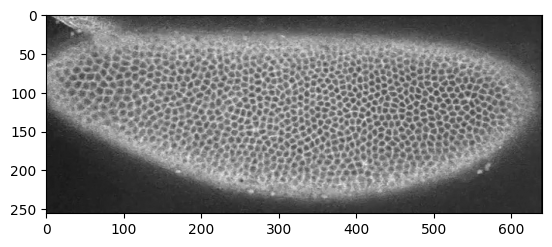

In [ ]:
image = skimage.io.imread('/content/frames/frame_00000.jpg', as_gray=True)
plt.imshow(image, cmap='gray')


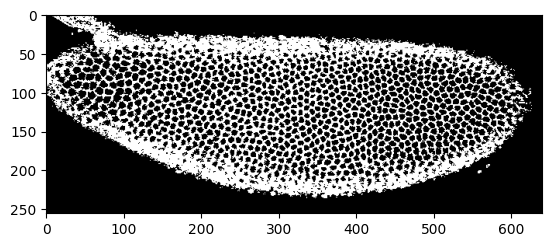

In [ ]:
img = (deepcopy(image) * 255).astype('uint8')
T = 100
upper_mask = img >= T
lower_mask = img < T
img[upper_mask] = 255
img[lower_mask] = 0
plt.imshow(img, cmap='gray')

In [ ]:
skimage.io.imsave('/content/frames/frame_00000_.jpg',img)

# Gaussian Division

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_float
from skimage.filters import gaussian
from copy import deepcopy

Text(0.5, 1.0, 'Corrected Image')

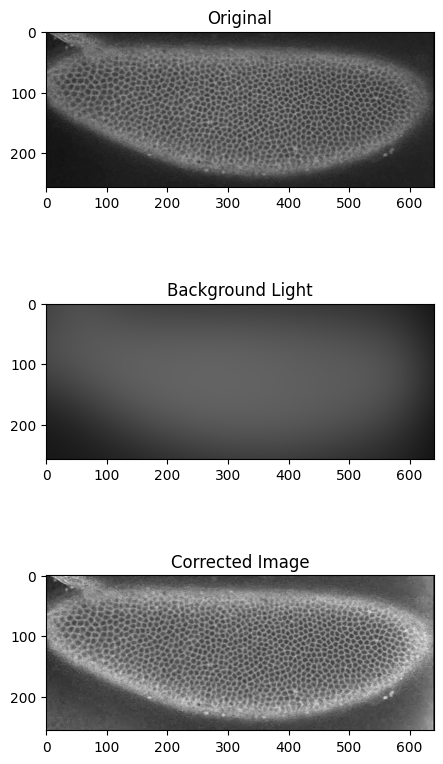

In [ ]:
fname='/content/frames/frame_00000.jpg'
image = io.imread(fname)
img = img_as_float(deepcopy(image))


approx_background = gaussian(img, sigma=50)
epsilon = 1e-6

corrected = img/(approx_background-epsilon)
corrected = corrected/corrected.max()

fig, axs = plt.subplots(3,1,figsize=(5,10))

axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original')

axs[1].imshow(approx_background, cmap='gray')
axs[1].set_title('Background Light')

axs[2].imshow(corrected, cmap='gray')
axs[2].set_title('Corrected Image')

I don't think this provides any valuable scaling that can't be done better by binarizing the image.

#Threshold Image to Create Mask

Text(0.5, 1.0, 'Final')

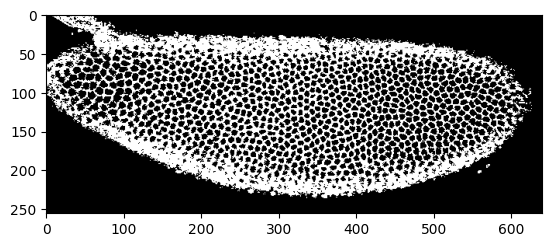

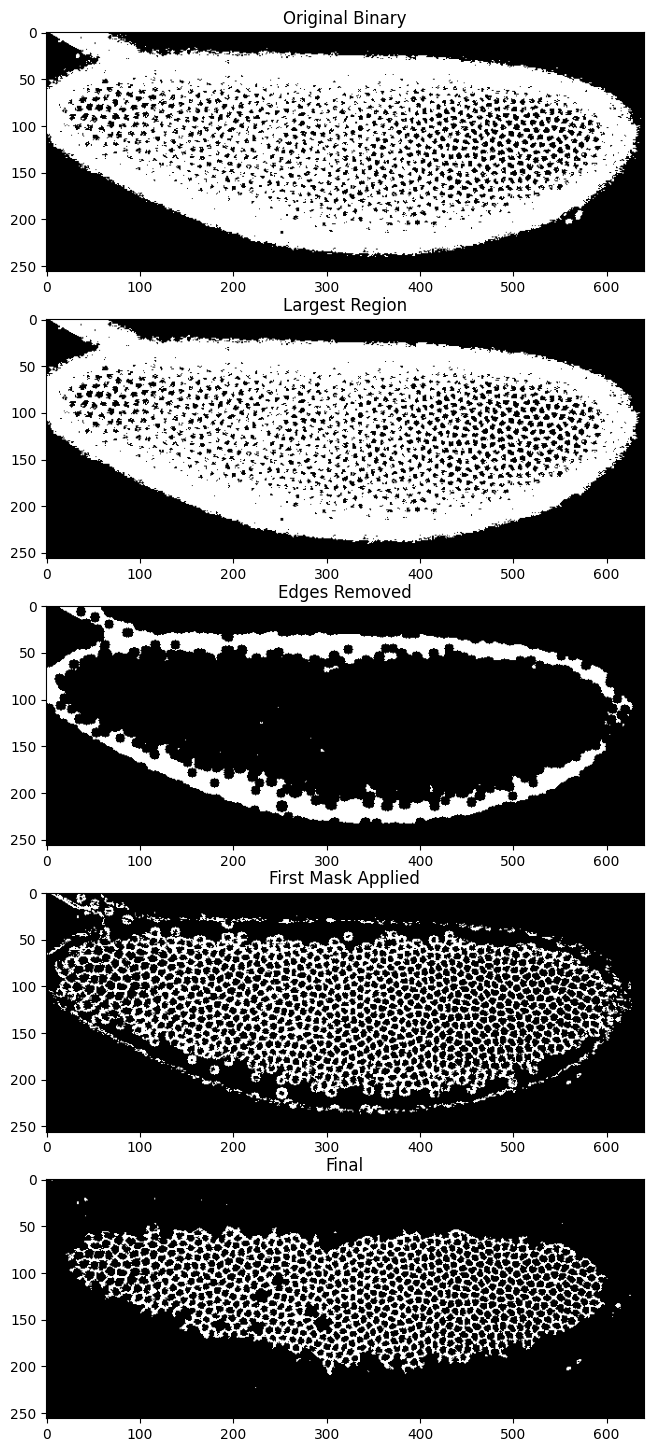

In [ ]:
#Load necessary packages
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, morphology, measure
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border, find_boundaries
from scipy.ndimage import distance_transform_edt
from copy import deepcopy

#Load image
img = io.imread('/content/drive/MyDrive/frames/frame_00000.jpg', as_gray=True)

#Binarize image via thresholding
im = (deepcopy(img) * 255).astype('uint8')
T = 100
upper_mask = im >= T
lower_mask = im < T
im[upper_mask] = 255
im[lower_mask] = 0
plt.imshow(im, cmap='gray')

#Get primary mask
binary = img > threshold_otsu(img)
labels = measure.label(binary)
regions = measure.regionprops(labels)
largest_region = max(regions, key=lambda r:r.area)
mask = labels == largest_region.label
eroded = morphology.erosion(mask, morphology.disk(5))
cleaned = binary & eroded


#Get secondary mask
dist_inward = distance_transform_edt(~cleaned)
## Apply averaging to fix edge intensity
mean_dist = np.mean(dist_inward[dist_inward > 0])
inner_area = dist_inward > (0.25*mean_dist)
final_mask = (im > 0) & inner_area

#Get resulting image
masked_result = np.zeros_like(im)
masked_result[final_mask] = im[final_mask]

#Plot images
fig,axs = plt.subplots(5,1, figsize=(10,18))

axs[0].imshow(binary, cmap='gray')
axs[0].set_title('Original Binary')
axs[1].imshow(mask, cmap='gray')
axs[1].set_title('Largest Region')
axs[2].imshow(cleaned, cmap='gray')
axs[2].set_title('Edges Removed')
axs[3].imshow(im*~cleaned,cmap='gray')
axs[3].set_title('First Mask Applied')
axs[4].imshow(masked_result, cmap='gray')
axs[4].set_title('Final')

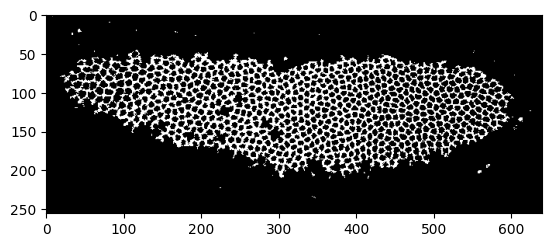

In [ ]:
#Show final mask from thresholding method
plt.imshow(masked_result, cmap='gray')

# Watershedding Segmentation Mask

(256, 640) (256, 640)


Text(0.5, 1.0, 'Final')

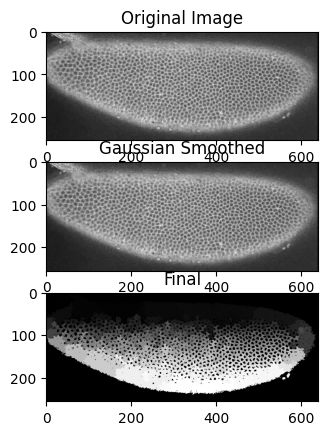

In [ ]:
#Load necessary packages
import numpy as np
import matplotlib.pyplot as plt

from skimage import io
from skimage.filters import gaussian, sobel, threshold_otsu
from skimage.feature import peak_local_max
from skimage.measure import label
from skimage.segmentation import watershed

from scipy.ndimage import distance_transform_edt

#Load image from disk
fpath = '/content/drive/MyDrive/frames/frame_00000.jpg'
img = io.imread(fpath, as_gray=True)

#Smooth image
#smoothed = gaussian(img,sigma=0.1)
gradient = sobel(img)

#Create labels via watershed method
binary = smoothed > threshold_otsu(smoothed)
distance = distance_transform_edt(binary)
print(distance.shape,binary.shape)
local_maxs_coords = peak_local_max(distance, labels=binary, footprint=np.ones((15, 15)))
local_maxs = np.zeros_like(distance, dtype=bool)
local_maxs[tuple(local_maxs_coords.T)] = True
markers = label(local_maxs)
labels = watershed(gradient, markers, mask=binary)

fig, axs = plt.subplots(3,1)

axs[0].imshow(img, cmap='grey')
axs[0].set_title('Original Image')
axs[1].imshow(smoothed, cmap='grey')
axs[1].set_title('Gaussian Smoothed')
axs[2].imshow(img,cmap='grey')
axs[2].imshow(labels, cmap='grey')
axs[2].set_title('Final')

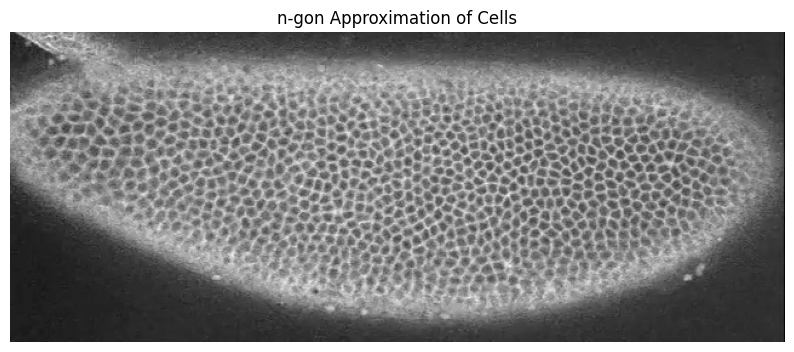